## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install and use [OpenSlide](https://openslide.org/), the only non-Python dependency. Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, though, you'll need to install and run OpenSlide locally.

### Training data

This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains a few slides and tumor masks prepared in advance with ASAP. This amount of data (or less!) should be sufficient for your project. The goal is to build a thoughtful end-to-end prototype, not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442) discussed in class. If you would like more data than has been provided, you will need to use ASAP to convert it into an appropriate format. 


In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [3]:
#read data from google bucket
slides_num = ['002', '012', '023', '059', '075', '094', '101']
data_url = 'https://storage.googleapis.com/applied-deep-learning/Final_Project/'
slides_path = [('tumor_' + num + '.tif') for num in slides_num]
tumor_masks_path = [('tumor_' + num + '_mask.tif') for num in slides_num]

slides = []
tumor_masks = []

for sp in slides_path:
  slide_url = data_url+sp
  !curl -O $slide_url
  slides.append(open_slide(sp))
  
for tmp in tumor_masks_path:
  mask_url = data_url+tmp
  !curl -O $mask_url
  tumor_masks.append(open_slide(tmp))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1602M  100 1602M    0     0   145M      0  0:00:11  0:00:11 --:--:--  137M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1551M  100 1551M    0     0   146M      0  0:00:10  0:00:10 --:--:--  133M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1609M  100 1609M    0     0   129M      0  0:00:12  0:00:12 --:--:-- 93.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1412M  100 1412M    0     0   142M      0  0:00:09  0:00:09 --:--:--  136M
  % Total    % Received % Xferd  Average Speed   Tim

In [0]:
# Verify downsampling works as expected
for slide in slides:
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

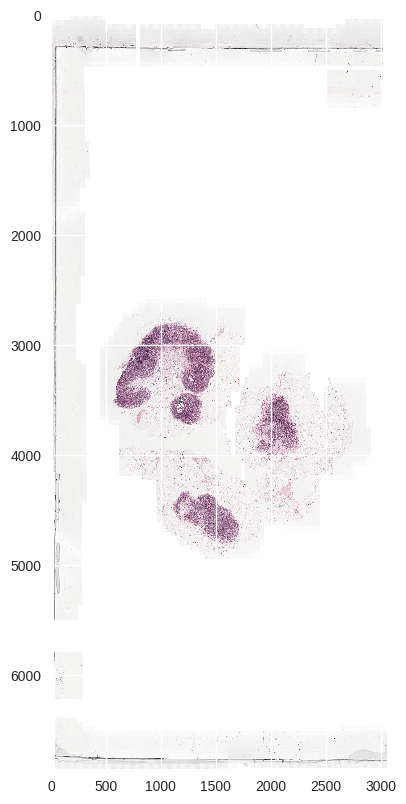

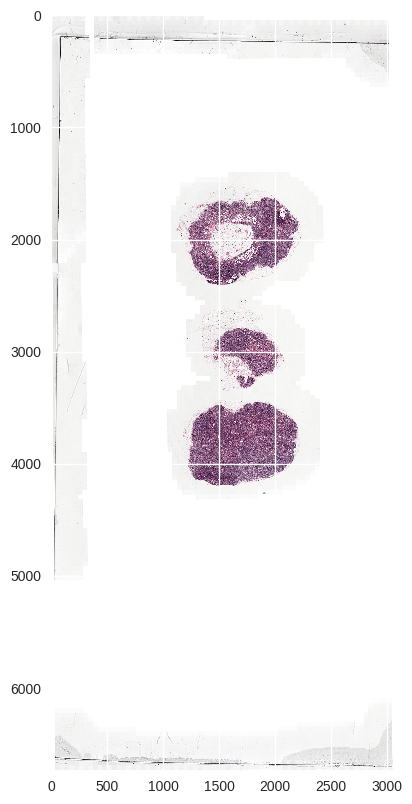

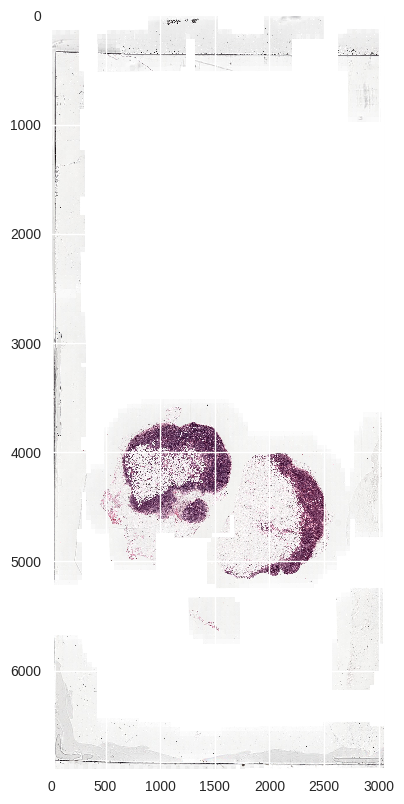

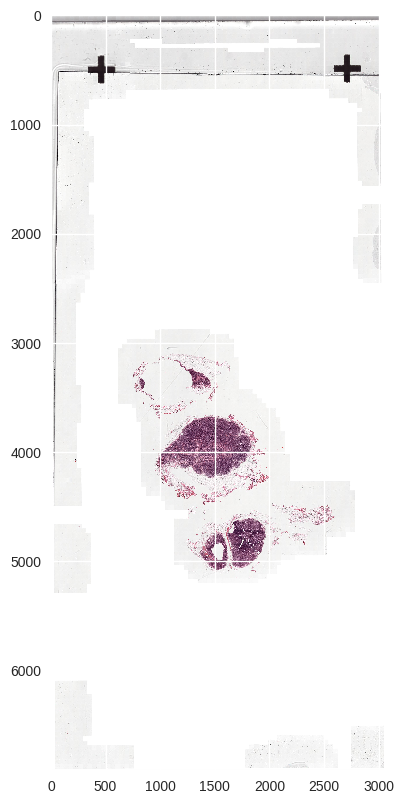

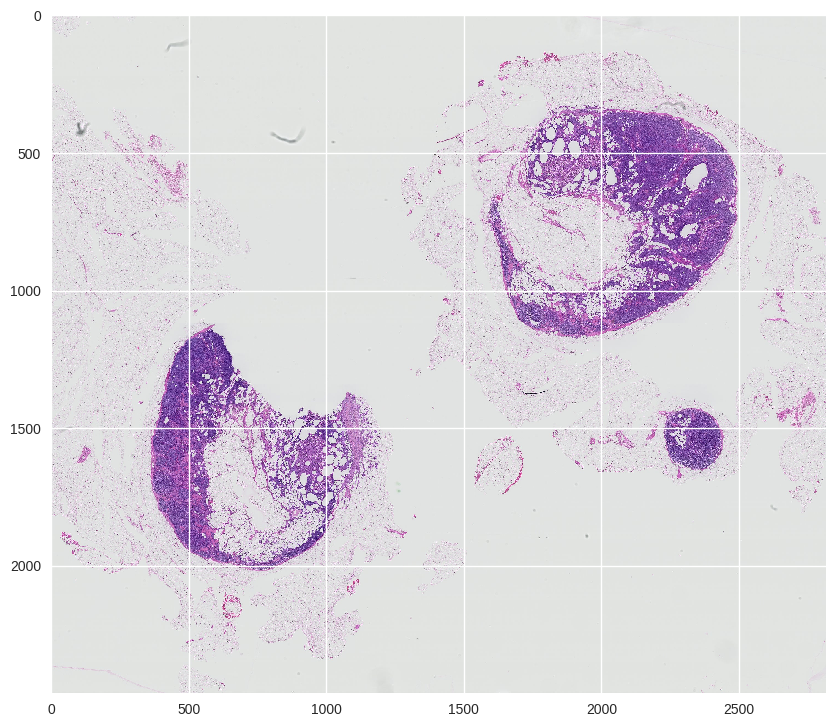

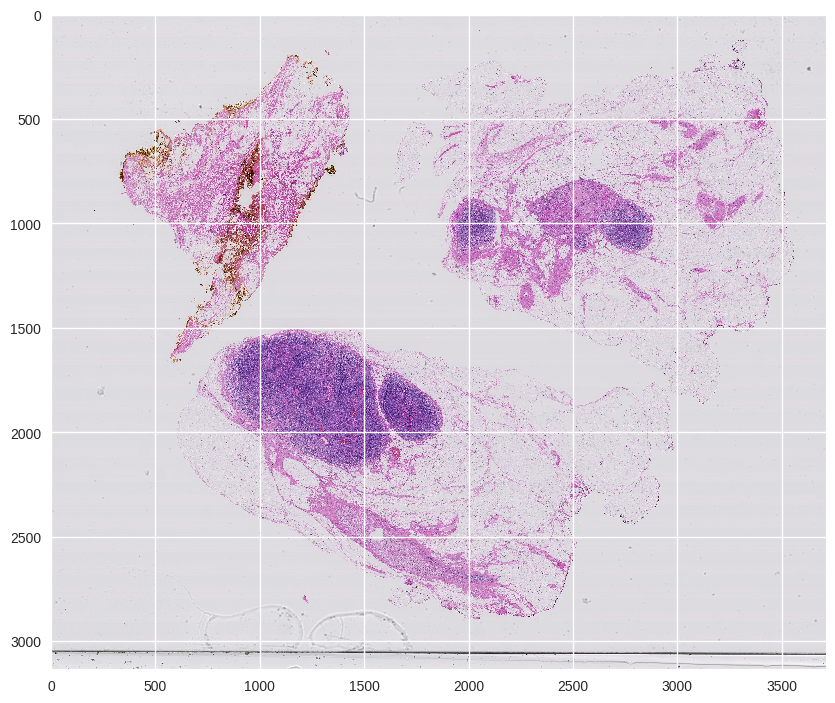

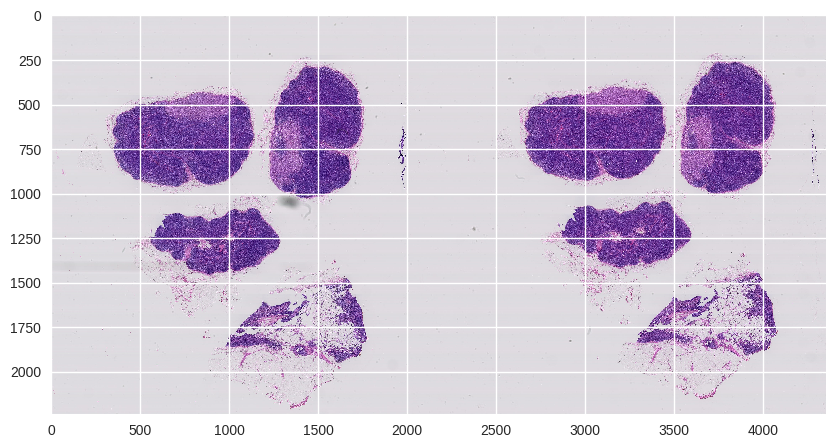

In [6]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.
for slide in slides:
  slide_image = read_slide(slide, 
                           x=0, 
                           y=0, 
                           level=5, 
                           width=slide.level_dimensions[5][0], 
                           height=slide.level_dimensions[5][1])

  plt.figure(figsize=(10,10), dpi=100)
  plt.imshow(slide_image)

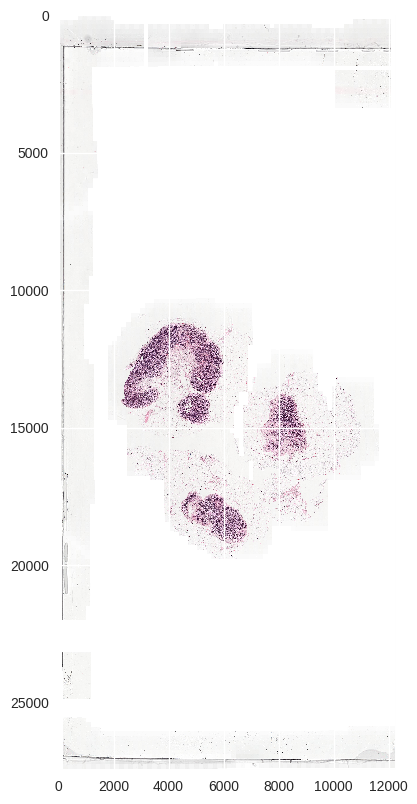

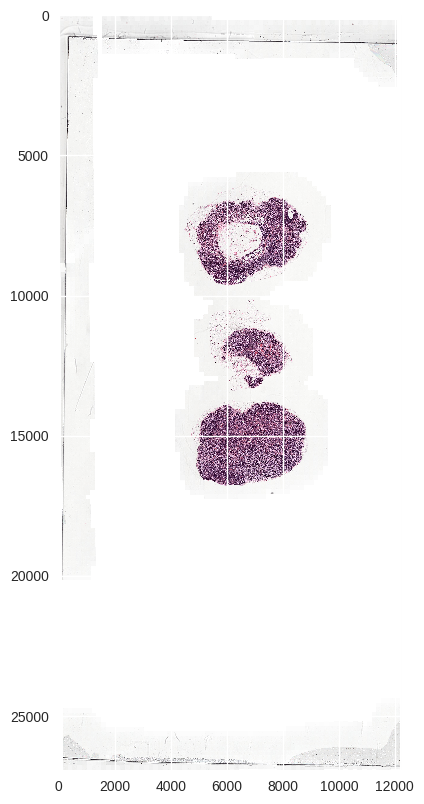

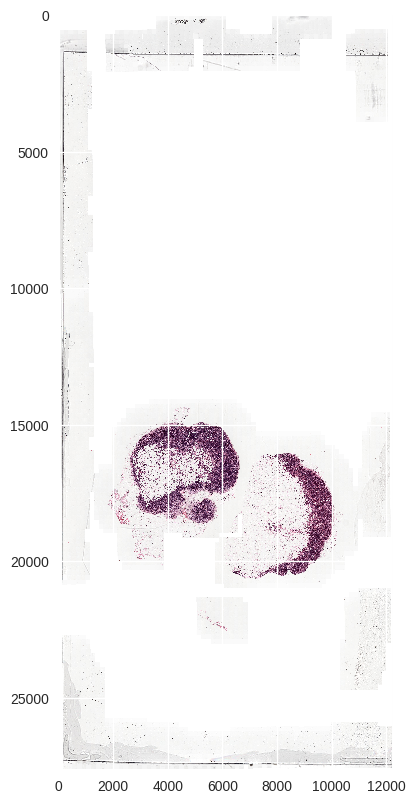

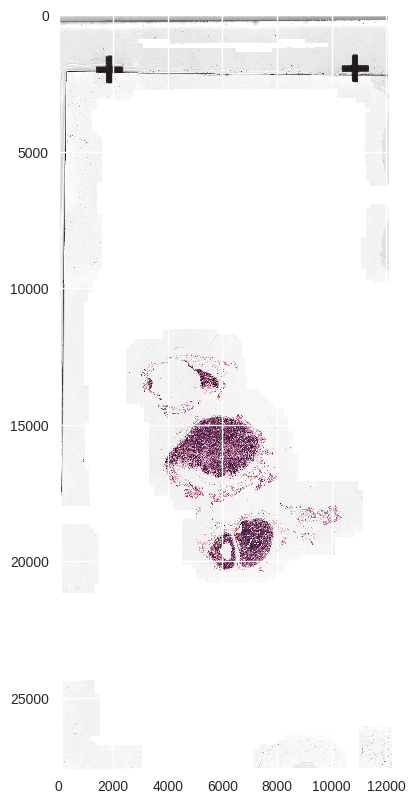

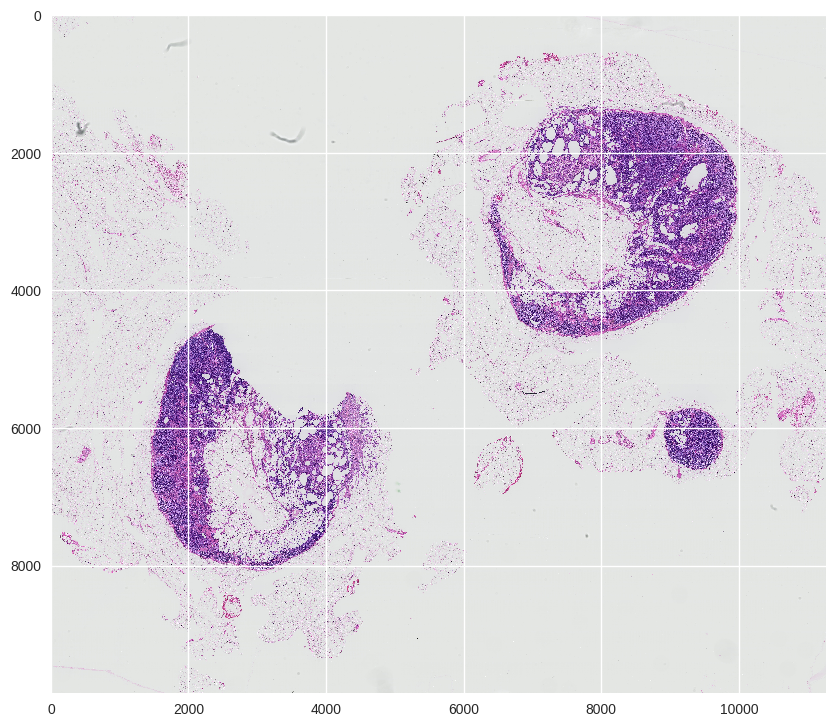

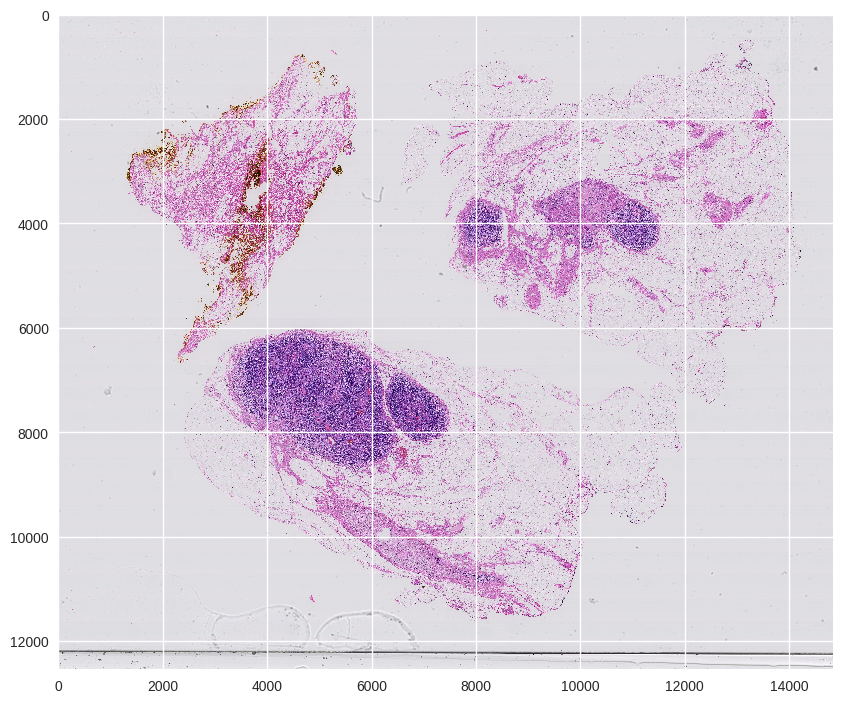

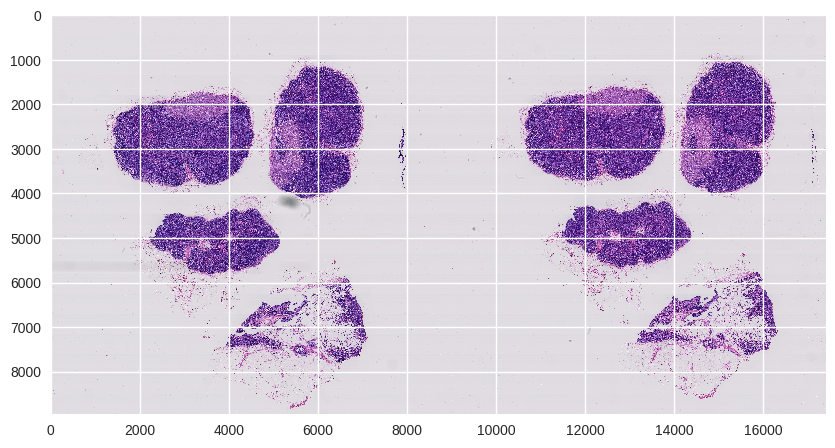

In [7]:
for slide in slides:
  slide_image = read_slide(slide, 
                           x=0, 
                           y=0, 
                           level=3, 
                           width=slide.level_dimensions[3][0], 
                           height=slide.level_dimensions[3][1])

  plt.figure(figsize=(10,10), dpi=100)
  plt.imshow(slide_image)

In [96]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
print("tumor_mask includes %d levels", len(tumor_mask.level_dimensions))


for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
   # assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
   # assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_064.tif with width: 97792, height: 220672
Read tumor mask from tumor_064_mask.tif
('Slide includes %d levels', 10)
('tumor_mask includes %d levels', 9)
Level 0, dimensions: (97792, 220672) downsample factor 1
Level 1, dimensions: (48896, 110336) downsample factor 2
Level 2, dimensions: (24448, 55168) downsample factor 4
Level 3, dimensions: (12224, 27584) downsample factor 8
Level 4, dimensions: (6112, 13792) downsample factor 16
Level 5, dimensions: (3056, 6896) downsample factor 32
Level 6, dimensions: (1528, 3448) downsample factor 64
Level 7, dimensions: (764, 1724) downsample factor 128
Level 8, dimensions: (382, 862) downsample factor 256
Level 9, dimensions: (191, 431) downsample factor 512


In [143]:
tumor_masks

[OpenSlide('tumor_002_mask.tif'),
 OpenSlide('tumor_012_mask.tif'),
 OpenSlide('tumor_023_mask.tif'),
 OpenSlide('tumor_059_mask.tif'),
 OpenSlide('tumor_075_mask.tif'),
 OpenSlide('tumor_094_mask.tif'),
 OpenSlide('tumor_101_mask.tif')]

In [142]:
slides

[OpenSlide('tumor_002.tif'),
 OpenSlide('tumor_012.tif'),
 OpenSlide('tumor_023.tif'),
 OpenSlide('tumor_059.tif'),
 OpenSlide('tumor_075.tif'),
 OpenSlide('tumor_094.tif'),
 OpenSlide('tumor_101.tif')]

In [0]:
patches = []
tumor_patches = []
PATCH_SIZE = 80
for k,slide in enumerate(slides):
  mask_image = read_slide(tumor_masks[k],x=0,y=0,level = 7, width=tumor_masks[k].level_dimensions[7][0], height=tumor_masks[k].level_dimensions[7][1])

  if np.count_nonzero(mask_image) > 0:  #checks if there actually is tumor in the slide
    
    for j in range(0,slide.level_dimensions[7][1],PATCH_SIZE):
      for i in range(0,slide.level_dimensions[7][0],PATCH_SIZE):
        patch = read_slide(slide,i*128,j*128,level = 7, width = PATCH_SIZE,height = PATCH_SIZE) #patch from slide
        mask_patch = read_slide(tumor_masks[k],i*128,j*128,level = 7, width = PATCH_SIZE,height = PATCH_SIZE)  #corresponding patch from mask
        tumor_patch = mask_patch[:,:,0] #take only one channel of mask
        tissue_pixels = find_tissue_pixels(patch) #find how many tissue pixels are there slide patch
        tissue_pixels = list(tissue_pixels)
        percent_tissue = len(tissue_pixels) / float(patch.shape[0] * patch.shape[0]) * 100 #percentage tissue in the patch
        if percent_tissue > 0:  #check if percent tissue is more than 10, if yes, then append both the slide patch and mask patch
          patches.append(patch)
          tumor_patches.append(tumor_patch)

In [0]:
#check if the number of slide patches and the number of patches from the masks correspond
assert len(patches) == len(tumor_patches)

In [148]:
#convert both lists to numpy arrays

patches = np.array(patches)
tumor_patches = np.array(tumor_patches)

#assigning labels to each patch: 1 if there is at least one non-zero entry in the corresponding mask patch, 0 if not. 

labels = []

for array in tumor_patches:
  if np.count_nonzero(array) > 0:
    labels.append(1)
  else :
    labels.append(0)
    
#converting to numpy array
labels = np.array(labels)


#checking the indices where the labels are 1
np.where(labels == 1)

(array([ 48, 155, 261, 262, 280, 293, 393, 460, 461, 483, 484, 492, 493,
        545, 546, 557, 558, 565, 644, 645, 646, 650, 651, 652, 658, 659,
        666, 667, 672, 673, 680, 686, 693, 694]),)

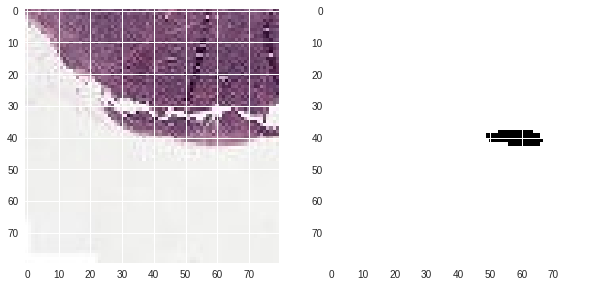

In [157]:
#plotting slide patch and mask patch at one of the above indices to see if the labels make sense
plt.figure(figsize= (10,5))
plt.subplot(1, 2, 1)
plt.imshow(patches[155]) 
plt.subplot(1,2,2)
plt.imshow(tumor_patches[155])

In [151]:
len(labels[labels == 1])


34

In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

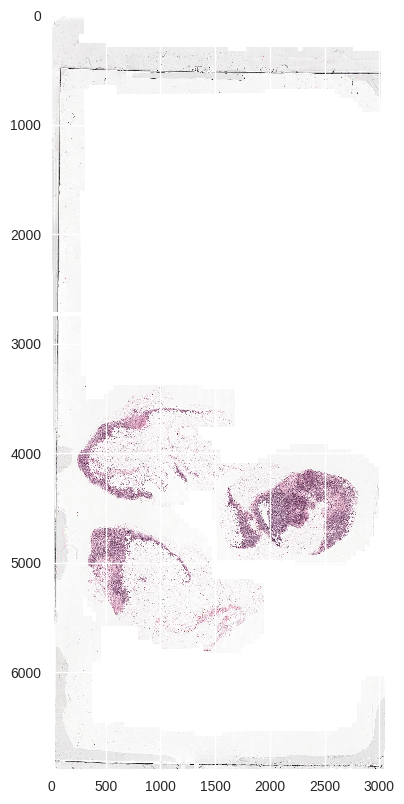

In [106]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

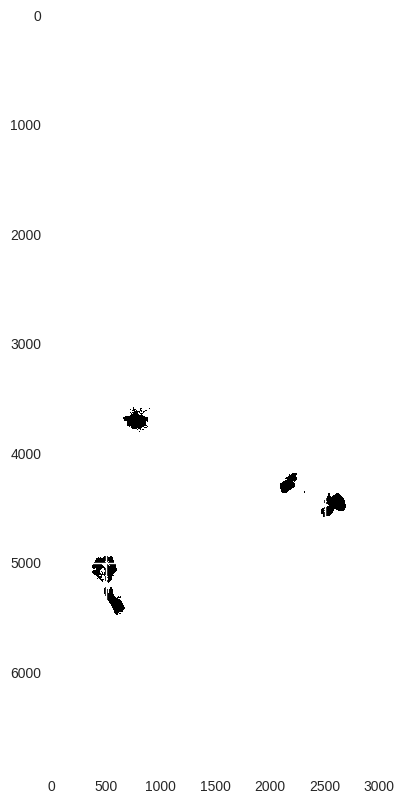

In [107]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

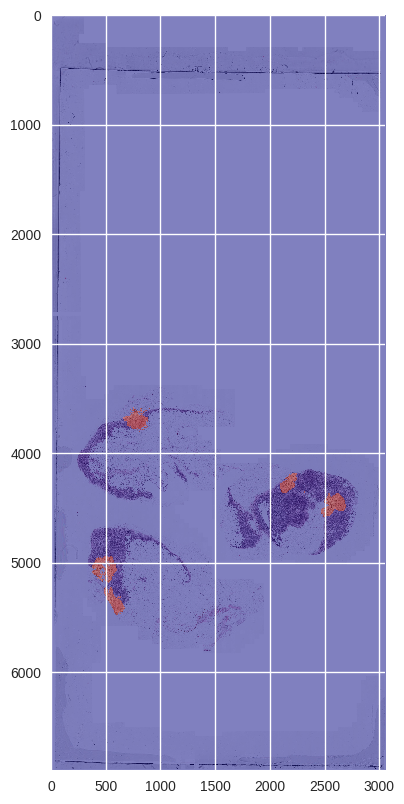

In [108]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

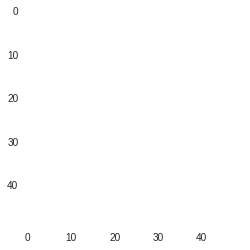

In [112]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(region)

977922 tissue_pixels pixels (2.1 percent of the image)


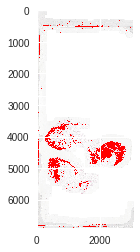

In [111]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)